In [7]:
from sys import path
path.append('src/')

import numpy as np
import matplotlib.pyplot as plt
from src.utils import load, plot
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

%matplotlib inline

# Load Model 

In [2]:
model = load_model('models/model_2019-6-17_12-29-19.hdf5')

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
______________________

# 11. Varied Background

In [3]:
mrk_files = load.mrk_files_from_folder('data/augmentation/11-varied_bgd/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

9000 of 9000


In [4]:
x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)
print(np.unique(y, return_counts=True))

9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
(array([-1,  0,  1]), array([3000, 3000, 3000], dtype=int64))


In [5]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, stratify=y, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(8100, 224, 224, 3) (8100,)
(900, 224, 224, 3) (900,)


In [6]:
outputs = Dense(units=64, activation='relu', name='dense_varied_background')(encoder.output)
outputs = Dense(units=3, activation='softmax', name='varied_background')(outputs)
model = Model(inputs=encoder.inputs, outputs=outputs)

for layer in model.layers:
    layer.trainable = (layer.name.find('varied_background') >= 0)

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(x_train / 255, y_train + 1, batch_size=32, epochs=30, validation_data=(x_val / 255, y_val + 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 112, 112, 32)      128       
__________

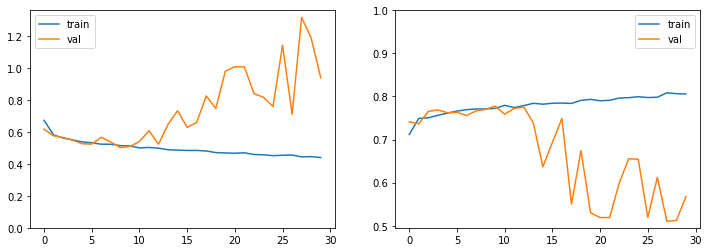

In [8]:
plot.plot_keras_hist(hist.history)

In [ ]:
y_pred = model.predict(x_val / 255).argmax(axis=1)

print(confusion_matrix(y_val + 1, y_pred))
print(classification_report(y_val + 1, y_pred))